In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import gcsfs
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import nzthermo as nzt


plt.rcParams["figure.figsize"] = (12, 8)

plt.rcParams["xtick.bottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["xtick.labelbottom"] = False
plt.rcParams["ytick.labelleft"] = False

In [3]:
fs = gcsfs.GCSFileSystem(token="anon")
mapper = fs.get_mapper(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr"
)
ds = xr.open_zarr(mapper)
ds

<xarray.Dataset> Size: 89TB
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

In [4]:
pressure = ds.coords["level"].to_numpy().astype(np.float32) * 100.0  # (Pa) (13,)
temperature = (
    ds["temperature"].isel(time=slice(0, 30)).to_numpy().astype(np.float32)
)  # (K) (30, 13, 721, 1440)
specific_humidity = (
    ds["specific_humidity"].isel(time=slice(0, 30)).to_numpy().astype(np.float32)
)  # (K) (30, 13, 721, 1440)

In [5]:
# - weatherbench's levels are in reverse order
# - non vertical dimensions are flattened like (T, Z, Y, X) -> (T*Y*X, Z) || (N, Z)
P = pressure[::-1]
Z = len(P)
T = np.moveaxis(temperature[:, ::-1, :, :], 1, -1).reshape(-1, Z)  # (N, Z)
print(f"{temperature.shape} -> {T.shape} || (T, Z, Y, X) -> (N, Z)")
Td = nzt.dewpoint_from_specific_humidity(
    P[np.newaxis, :],
    np.moveaxis(specific_humidity[:, ::-1, :, :], 1, -1).reshape(-1, Z),
)  # (N, Z)

(30, 13, 721, 1440) -> (31147200, 13) || (T, Z, Y, X) -> (N, Z)


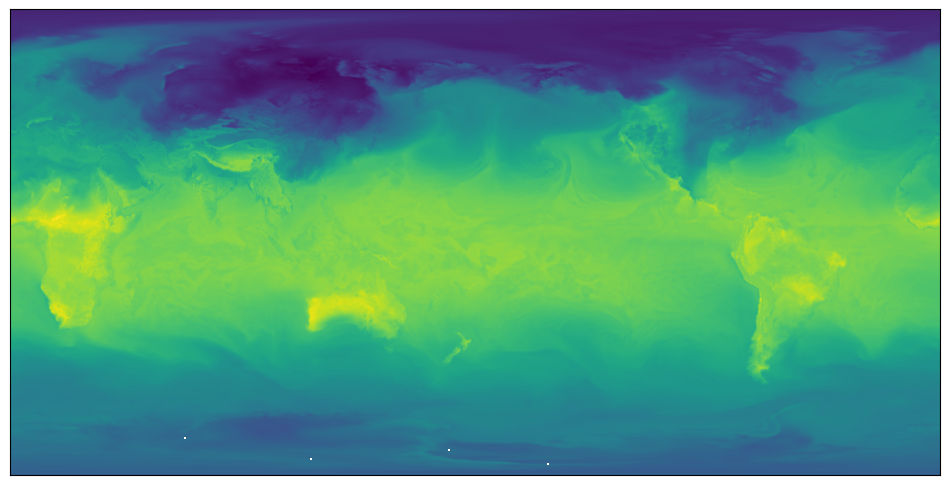

In [6]:
T0 = T[:, 0]
Td0 = Td[:, 0]

lr = nzt.moist_lapse(P, T0, Td0).reshape(
    (temperature.shape[0],) + temperature.shape[2:] + (Z,)
)  # (T, Y, X, Z)
plt.imshow(lr[0, ..., 0])

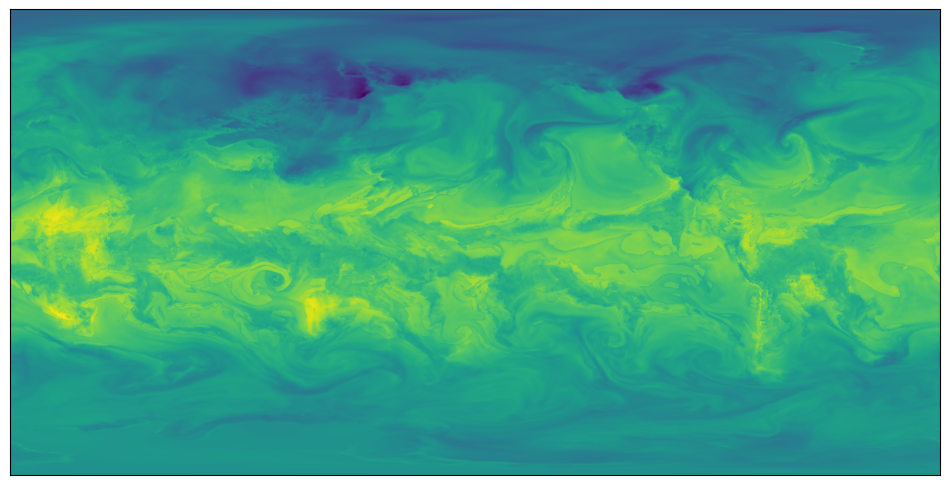

In [7]:
dcape = nzt.downdraft_cape(P, T, Td)  # (T*Y*X,) || (N,)
dcape = dcape.reshape((temperature.shape[0],) + temperature.shape[2:])  # (T, Y, X)
plt.imshow(dcape[0, ...])

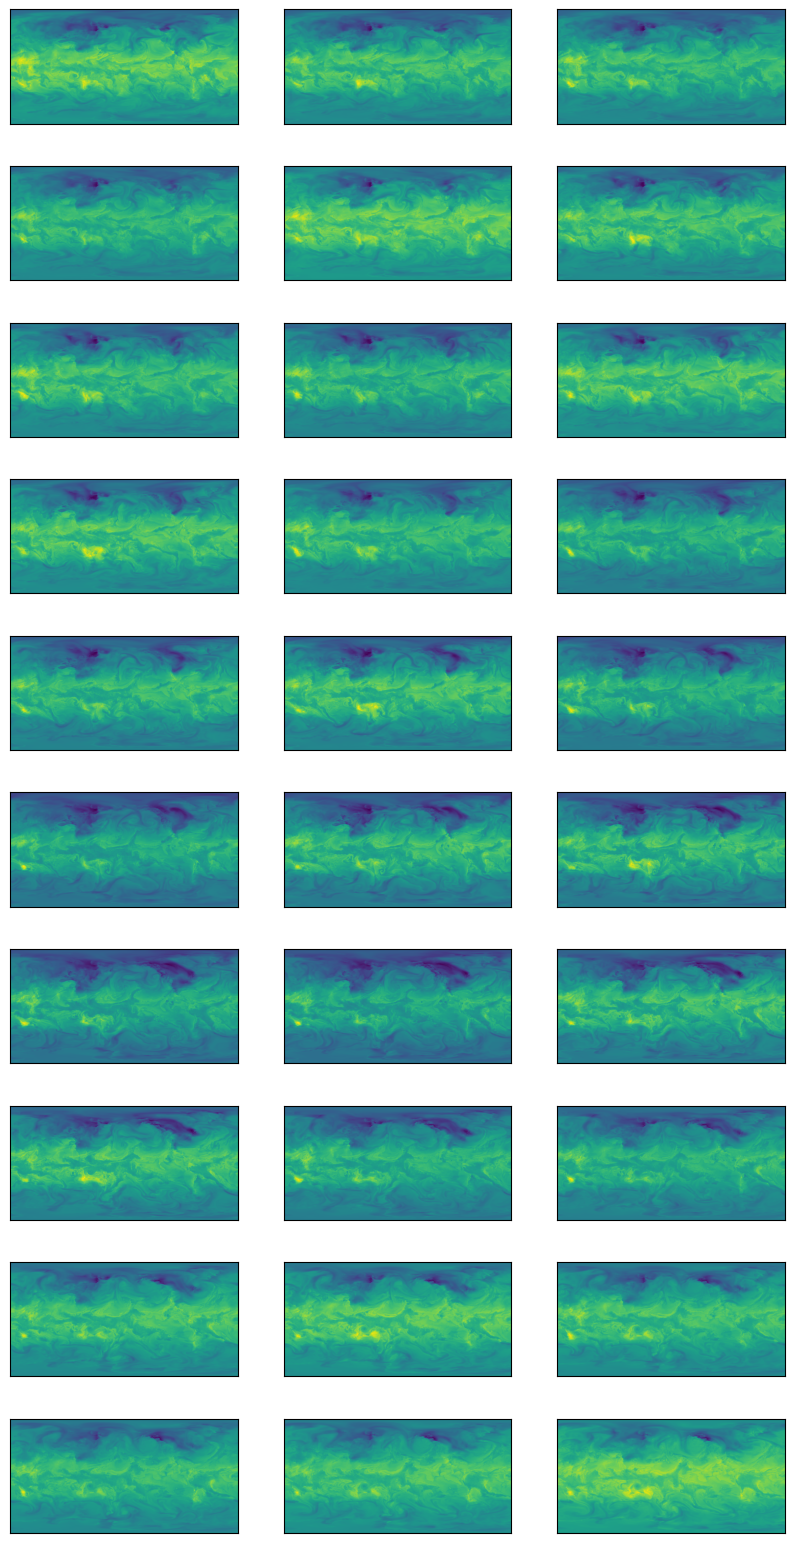

In [8]:
fig, axes = plt.subplots(dcape.shape[0] // 3, 3, figsize=(10, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(dcape[i], cmap="viridis")

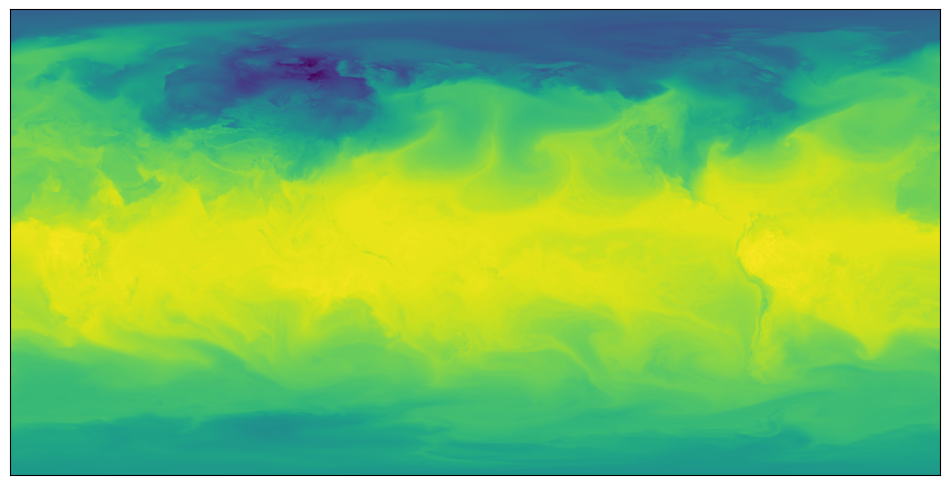

In [9]:
P0 = P[:1].repeat(T.shape[0])
T0 = T[:, 0]  # (T*Y*X)
Td0 = Td[:, 0]  # (T*Y*X)


wb = nzt.wet_bulb_temperature(P0, T0, Td0).reshape(
    (temperature.shape[0],) + temperature.shape[2:]
)


plt.imshow(wb[0, ...])